In [1]:
# Setting up Notebook
% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations
import string
import networkx as nx
import matplotlib as mpl
import tweepy as tw
# These two lines suppress warnings that sometimes
# occur when making visualizations
import warnings
warnings.filterwarnings('ignore')


### Twiiter Authentication

In [2]:
tokens = []
# Order: Access Token, Access Token Secret, Consumer Key, Consumer SecretAccess
with open("twitter_cred.txt", 'r') as fin:
    for line in fin:
        if line[0] != '#': # Not a comment line
            tokens.append(line.rstrip('\n'))

auth = tw.OAuthHandler(tokens[2], tokens[3])
auth.set_access_token(tokens[0], tokens[1])
api = tw.API(auth, wait_on_rate_limit=True)
user = api.me()
print("Twitter Screen Name: ", user.screen_name)


Twitter Screen Name:  amit_darekar27


### Function to get unique hashtags and most common pairs

In [3]:
def pairs(num_tweets, search, pairs):
    '''           
    Parameters
    ----------
    num_tweets : Number of tweets to fetch
    search : Search term
    pairs : most common tokens
    
    Returns
    -------
    A tuple of 2 containing the set of unique hashtags, 
    most common pairs and the counts of each pair(pair, count)

    top_tkns will look something like this:
    ---------------------------------------
    {'ai', 'analytics', 'bigdata', 'datascience', 'iot'}

    top_pairs will look something like this:
    ----------------------------------------
    [(('analytics', 'iot'), 53),
     (('analytics', 'bigdata'), 52),
     (('bigdata', 'datascience'), 45),
     (('ai', 'bigdata'), 43)]
    '''
    
    tweets = []

    # Get the tweets
    
    results = tw.Cursor(api.search, q=search).items(num_tweets)
    
    # Build list from Twitter search results
    for result in results:
        tweets.append(result.text)
    
    tkns = set()
    cnt = Counter()

    # Iterate over all tweets
    for tweet in tweets:
        tags = sorted([tag.lstrip("#").rstrip(string.punctuation).lower() 
                for tag in tweet.split() if tag.startswith("#")])

        # We now build our set of tokens
        for tag in tags:
            tkns.add(tag)

        for paired_tags in combinations(tags, 2):
            cnt[paired_tags] += 1

    # Now we go through pair counter for top pairs to build a network.
    top_tkns = set()
    num_top_pairs = pairs

    # Get most common pairs
    top_pairs = cnt.most_common(num_top_pairs)

    # Get most frequenly used tokens
    for pair, count in top_pairs:
        top_tkns.add(pair[0])
        top_tkns.add(pair[1])

    return top_tkns, top_pairs

In [4]:
token1, pairs1=pairs(500, '#analytics', 4)

In [5]:
token2, pairs2=pairs(200, '#bigdata', 3)

### Create Graph

In [6]:
def graph(token, pairs):
    '''           
    Parameters
    ----------
    token : set of unique hashtags[returned from Problem1]
    pairs : most common pairs and the counts of each pair(pair, count)[returned from Problem1]
    
    Returns
    -------
    A tuple of 2 containing axes object, 
    Graph object
    '''
    # No Axes, no Axes labels, white background

    fig, axs = plt.subplots(figsize=(12, 12))

    clrs = sns.color_palette("Paired")

    sns.set(style='white', font_scale=1.5)
    
    g = nx.Graph()

    g.add_nodes_from(list(token))

    for pair, count in pairs:
        g.add_edge(pair[0], pair[1], weight=count)

    # Now draw graph, use spectral layout

    pos = nx.spectral_layout(g)

    nx.draw_networkx_nodes(g, pos, with_labels=True,
                           node_size = 3000,
                           node_color=clrs[2],
                           node_shape='o',
                           alpha = 0.4)

    # Build up list of edges and weights for controlled plotting
    edges = []
    weights = []

    for n1, n2, dct in g.edges(data=True):
        edges.append((n1, n2))
        weights.append(dct['weight'])

    # Make normalized weights (scale to minimum weight)
    min_weight = min(weights)
    norm_weights = [int(weight/min_weight) for weight in weights]

    # Draw weighted edges, we pass in the edgelist so we can 
    # also pass in the edge weights individually
    nx.draw_networkx_edges(g, pos, edgelist=edges, 
                           width = norm_weights, 
                           edge_color=clrs.as_hex()[4],
                           alpha = 0.6)

    # Now label nodes, since we don't provide lables, it uses the 
    # default labels (which is what we want)
    nx.draw_networkx_labels(g, pos, font_size = 18,
                            font_color = clrs[1],
                            alpha = 1.0)

    axs.set_title('Hashtag Co-Occurance Plot')

    return axs, g

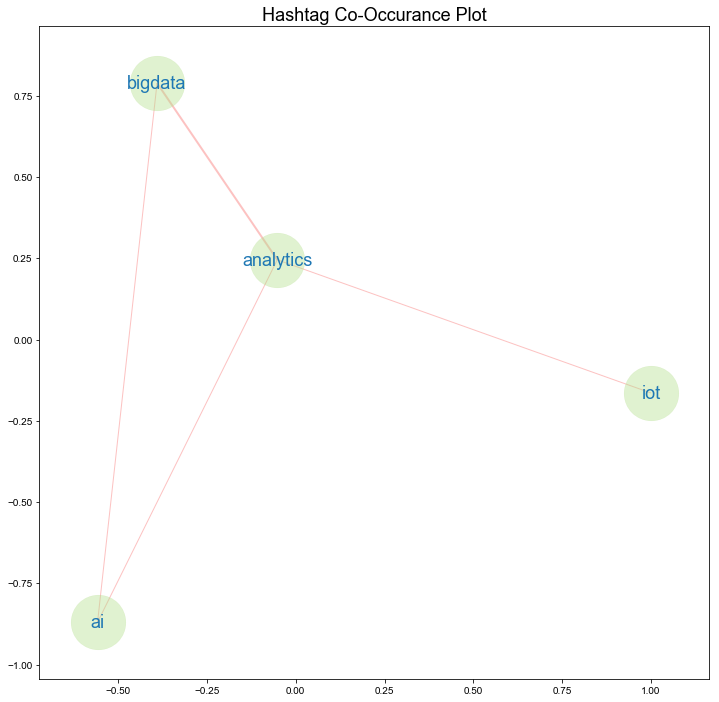

In [7]:
axs1, g1 = graph(token1, pairs1)

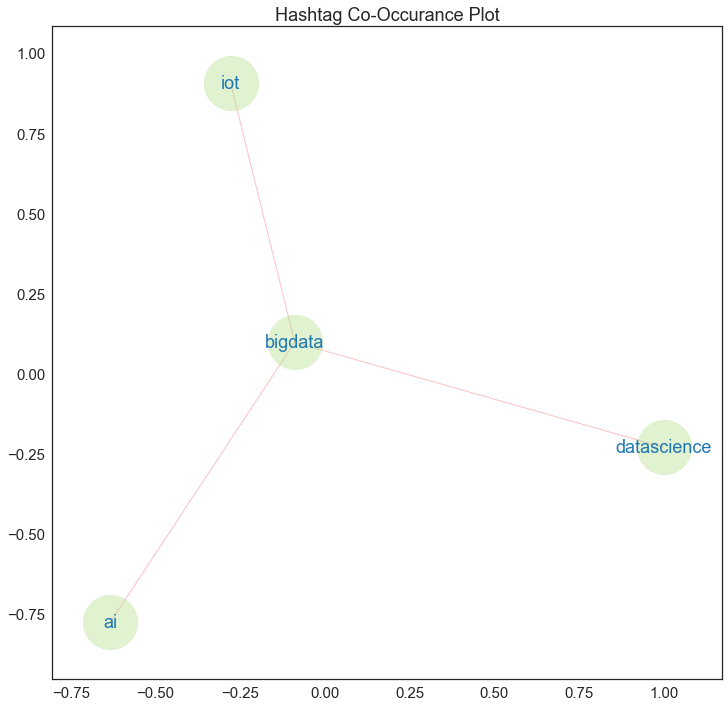

In [8]:
axs2, g2 = graph(token2, pairs2)